In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pettingzoo.classic import texas_holdem_v4

# =============== 卡牌相关的辅助函数 ===============

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def decode_visible_cards(obs_dict):
    """
    把 texa_holdem_v4 的 observation 向量前 52 位，解码成当前玩家能看到的所有牌
    （两张手牌 + 公共牌），返回 [(rank, suit), ...] 形式。
    """
    vec = np.asarray(obs_dict["observation"]).astype(int)
    card_bits = vec[:52]  # 前 52 维是 52 张牌
    cards = []
    for idx, bit in enumerate(card_bits):
        if bit == 1:
            suit = SUITS[idx // 13]
            rank = RANKS[idx % 13]
            cards.append((rank, suit))
    return cards


def get_street_from_obs(obs_dict):
    """
    根据当前能看到的牌的张数，粗略判断处于哪个阶段（street）：
    - 2 张：preflop
    - 5 张：flop
    - 6 张：turn
    - >=7 张：river
    返回 0/1/2/3
    """
    cards = decode_visible_cards(obs_dict)
    n = len(cards)
    if n <= 2:
        return 0  # preflop
    elif n <= 5:
        return 1  # flop
    elif n <= 6:
        return 2  # turn
    else:
        return 3  # river


def estimate_strength_from_cards(cards):
    """
    非常粗糙的牌力估计：
        0 = weak
        1 = medium
        2 = strong
    规则：
        - 有三条 / 以上，或者有同花(>=5 张同花色) -> strong
        - 有一对，或者出现 Q/K/A 这样的高牌 -> medium
        - 其他 -> weak
    """
    if not cards:
        return 0

    ranks = [r for (r, s) in cards]
    suits = [s for (r, s) in cards]

    rank_counts = Counter(ranks)
    max_same_rank = max(rank_counts.values())

    suit_counts = Counter(suits)
    max_same_suit = max(suit_counts.values())

    has_high = any(r in ["Q", "K", "A"] for r in ranks)

    # 三条 / 同花 -> strong
    if max_same_rank >= 3 or max_same_suit >= 5:
        return 2

    # 一对 或 至少一张高牌 -> medium
    if max_same_rank == 2 or has_high:
        return 1

    # 其他 -> weak
    return 0


def encode_state(obs_dict):
    """
    把观测编码成一个很小的离散状态：
        street: 0..3 (preflop, flop, turn, river)
        strength: 0..2 (weak, medium, strong)
    总共 4 * 3 = 12 个状态，返回 [0, 11] 的整数。
    """
    street = get_street_from_obs(obs_dict)              # 0..3
    strength = estimate_strength_from_cards(
        decode_visible_cards(obs_dict)
    )                                                   # 0..2
    return street * 3 + strength                        # 0..11


# =============== Rule-based 策略 ===============

def pick_legal_action(preferred, legal_actions, backup_order):
    """
    给定一个想要的动作 preferred（0/1/2/3），如果不合法，
    就按 backup_order 顺序找下一个合法动作。
    legal_actions: np.array / list of legal indices
    """
    legal_set = set(int(a) for a in legal_actions)
    if preferred in legal_set:
        return preferred
    for a in backup_order:
        if a in legal_set:
            return a
    # 理论上不会走到这里，保险起见
    return int(list(legal_set)[0])


def rule_based_action(obs_dict, verbose=False, who="player_0"):
    """
    非学习的 rule-based 策略：
    - 先根据 observation 得到 street 和 strength
    - 使用很简单的扑克牌直觉规则选择动作：
        preflop:
            strong  -> 优先 Raise, 否则 Call/Check
            medium  -> 优先 Call, 否则 Check
            weak    -> 优先 Check, 否则 Fold
        flop/turn/river:
            strong  -> Raise > Call > Check
            medium  -> Call > Check
            weak    -> Check > Fold
    动作编码：
        0 = Call
        1 = Raise
        2 = Fold
        3 = Check
    """
    mask = np.asarray(obs_dict["action_mask"])
    legal = np.where(mask > 0)[0]

    street = get_street_from_obs(obs_dict)
    cards = decode_visible_cards(obs_dict)
    strength = estimate_strength_from_cards(cards)

    if verbose:
        readable = [f"{r} of {s}" for (r, s) in cards]
        label = ["weak", "medium", "strong"][strength]
        street_name = ["preflop", "flop", "turn", "river"][street]
        print(f"[{who}] street={street_name} cards={readable} | strength={label}")

    # 0=Call, 1=Raise, 2=Fold, 3=Check
    if street == 0:  # preflop
        if strength == 2:      # strong
            action = pick_legal_action(1, legal, backup_order=[0, 3, 2])
        elif strength == 1:    # medium
            action = pick_legal_action(0, legal, backup_order=[3, 1, 2])
        else:                  # weak
            action = pick_legal_action(3, legal, backup_order=[2, 0, 1])
    else:          # flop / turn / river
        if strength == 2:
            action = pick_legal_action(1, legal, backup_order=[0, 3, 2])
        elif strength == 1:
            action = pick_legal_action(0, legal, backup_order=[3, 1, 2])
        else:
            action = pick_legal_action(3, legal, backup_order=[2, 0, 1])

    return int(action)


def play_episode_rule_vs_random(verbose=False):
    """
    运行一整局游戏：
        - player_0 使用 rule-based 策略
        - player_1 使用随机合法动作
    返回：player_0 的总 reward（>0 胜，<0 负，=0 平）
    """
    env = texas_holdem_v4.env()
    env.reset()
    total_reward_p0 = 0.0

    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()

        # 累积我方（player_0）的 reward
        if agent == "player_0":
            total_reward_p0 += reward

        done = termination or truncation
        if done:
            action = None
        else:
            mask = np.asarray(obs["action_mask"])
            legal = np.where(mask > 0)[0]

            if agent == "player_0":
                action = rule_based_action(obs, verbose=verbose, who=agent)
            else:
                # 对手：简单随机合法动作
                action = int(np.random.choice(legal))

        env.step(action)

    env.close()
    return total_reward_p0


def collect_rule_based_stats(num_episodes=1000):
    """
    多次运行 rule-based vs random，统计胜率等。
    """
    rewards = []
    for _ in range(num_episodes):
        r = play_episode_rule_vs_random(verbose=False)
        rewards.append(r)

    rewards = np.array(rewards)
    win_rate = np.mean(rewards > 0)
    tie_rate = np.mean(rewards == 0)
    loss_rate = np.mean(rewards < 0)

    print(f"[Rule-based vs Random] over {num_episodes} episodes:")
    print(f"  Win rate : {win_rate:.3f}")
    print(f"  Tie rate : {tie_rate:.3f}")
    print(f"  Loss rate: {loss_rate:.3f}")
    print(f"  Mean reward: {rewards.mean():.3f}")
    return rewards


# =============== Shallow Q-learning（表格 Q） ===============

def shallow_train(
    num_episodes=5000,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.2,
    epsilon_decay=0.999,
    epsilon_min=0.05,
):
    """
    对 texas_holdem_v4 做非常简化的 tabular Q-learning：

    - 只控制 player_0
    - player_1 始终是随机合法动作
    - 状态空间：encode_state() 给出的 12 个状态
    - 动作空间：4 个动作 (call, raise, fold, check)
    - 奖励：每次轮到 player_0 时，env.last() 返回的是「上一次
      player_0 动作之后累计得到的 reward」，用来更新 Q 表。
    """
    n_states = 12
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    episode_rewards = []

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()

        prev_state = None
        prev_action = None
        total_reward_p0 = 0.0

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            done = termination or truncation

            if agent == "player_0":
                # reward 是「上一次 player_0 行动」以来的收益
                total_reward_p0 += reward

                # 1) 用这次看到的 reward 更新上一个 (s,a)
                if prev_state is not None:
                    current_state = encode_state(obs)
                    # 终局就不 bootstrapping
                    best_next = 0.0 if done else np.max(Q[current_state])
                    old = Q[prev_state, prev_action]
                    Q[prev_state, prev_action] = (
                        old + alpha * (reward + gamma * best_next - old)
                    )

                # 2) 决定这一次要做的动作
                if done:
                    action = None
                    prev_state = None
                    prev_action = None
                else:
                    state = encode_state(obs)
                    mask = np.asarray(obs["action_mask"])
                    legal_actions = np.where(mask > 0)[0]

                    # epsilon-greedy（只在合法动作里面选）
                    if np.random.rand() < epsilon:
                        action = int(np.random.choice(legal_actions))
                    else:
                        q_row = Q[state].copy()
                        illegal_mask = np.ones_like(q_row, dtype=bool)
                        illegal_mask[legal_actions] = False
                        q_row[illegal_mask] = -1e9
                        action = int(np.argmax(q_row))

                    prev_state = state
                    prev_action = action
            else:
                # 对手：随机合法动作
                if done:
                    action = None
                else:
                    mask = np.asarray(obs["action_mask"])
                    legal_actions = np.where(mask > 0)[0]
                    action = int(np.random.choice(legal_actions))

            env.step(action)

        env.close()

        # 线性衰减探索率
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        episode_rewards.append(total_reward_p0)

    return Q, np.array(episode_rewards)


def play_episode_q_vs_random(Q, epsilon=0.0, verbose=False):
    """
    使用训练好的 Q 表进行对局：
    - player_0: Q 表 + epsilon-greedy
    - player_1: 随机
    """
    env = texas_holdem_v4.env()
    env.reset()
    total_reward_p0 = 0.0

    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
        done = termination or truncation

        if agent == "player_0":
            total_reward_p0 += reward

            if done:
                action = None
            else:
                state = encode_state(obs)
                mask = np.asarray(obs["action_mask"])
                legal_actions = np.where(mask > 0)[0]

                if np.random.rand() < epsilon:
                    action = int(np.random.choice(legal_actions))
                else:
                    q_row = Q[state].copy()
                    illegal_mask = np.ones_like(q_row, dtype=bool)
                    illegal_mask[legal_actions] = False
                    q_row[illegal_mask] = -1e9
                    action = int(np.argmax(q_row))
        else:
            if done:
                action = None
            else:
                mask = np.asarray(obs["action_mask"])
                legal_actions = np.where(mask > 0)[0]
                action = int(np.random.choice(legal_actions))

        env.step(action)

    env.close()
    return total_reward_p0


def evaluate_q_policy(Q, num_episodes=1000):
    """
    评估 shallow Q-learning 策略，对手仍然随机。
    打印胜率 / 平局率 / 期望 reward。
    """
    rewards = []
    for _ in range(num_episodes):
        r = play_episode_q_vs_random(Q, epsilon=0.0, verbose=False)
        rewards.append(r)
    rewards = np.array(rewards)

    win_rate = np.mean(rewards > 0)
    tie_rate = np.mean(rewards == 0)
    loss_rate = np.mean(rewards < 0)

    print(f"[Q-learning vs Random] over {num_episodes} episodes:")
    print(f"  Win rate : {win_rate:.3f}")
    print(f"  Tie rate : {tie_rate:.3f}")
    print(f"  Loss rate: {loss_rate:.3f}")
    print(f"  Mean reward: {rewards.mean():.3f}")
    return rewards


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(episode_rewards, window=50):
    """
    对 shallow Q-learning 的 episode reward 做滑动平均，画学习曲线。
    """
    rewards = np.asarray(episode_rewards)
    if len(rewards) < window:
        window = len(rewards)
    cumsum = np.cumsum(np.insert(rewards, 0, 0))
    ma = (cumsum[window:] - cumsum[:-window]) / float(window)

    plt.figure(figsize=(8, 4))
    plt.plot(range(window, len(rewards) + 1), ma)
    plt.xlabel("Episode")
    plt.ylabel(f"{window}-episode moving avg reward")
    plt.title("Shallow Q-learning Learning Curve")
    plt.grid(True)
    plt.show()


def plot_q_heatmap(Q):
    """
    把 12x4 的 Q 表画成热力图：
    - 行：12 个离散状态
    - 列：四个动作 call / raise / fold / check
    """
    plt.figure(figsize=(8, 5))
    im = plt.imshow(Q, aspect="auto", cmap="Blues", vmin=-1, vmax=1)
    plt.colorbar(im, label="Q-value")
    plt.yticks(range(12), [f"s{idx}" for idx in range(12)])
    plt.xticks(range(4), ["call(0)", "raise(1)", "fold(2)", "check(3)"])
    plt.title("Shallow Q-learning Q-table Heatmap")

    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            plt.text(j, i, f"{Q[i, j]:.2f}", ha="center", va="center", fontsize=7)
    plt.tight_layout()
    plt.show()


def compare_rule_vs_q(rule_rewards, q_rewards):
    """
    简单对比 rule-based 和 shallow Q-learning：
    - 打印两者的平均 reward 和 win rate
    - 画一个 win rate 的柱状图
    """
    rule_rewards = np.asarray(rule_rewards)
    q_rewards = np.asarray(q_rewards)

    def stats(rs):
        return rs.mean(), np.mean(rs > 0)

    m_rule, win_rule = stats(rule_rewards)
    m_q, win_q = stats(q_rewards)

    print("========== Comparison: Rule-based vs Shallow Q-learning ==========")
    print(f"Rule-based: mean reward={m_rule:.3f}, win rate={win_rule:.3f}")
    print(f"Shallow Q:  mean reward={m_q:.3f}, win rate={win_q:.3f}")

    plt.figure(figsize=(5, 4))
    plt.bar(["Rule-based", "Shallow Q"], [win_rule, win_q])
    plt.ylabel("Win rate")
    plt.ylim(0, 1)
    plt.title("Win Rate Comparison vs Random Opponent")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()


[Rule-based vs Random] over 500 episodes:
  Win rate : 0.600
  Tie rate : 0.012
  Loss rate: 0.388
  Mean reward: 0.568


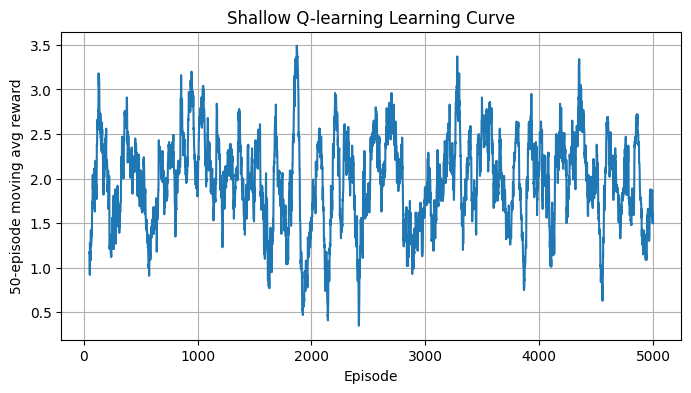

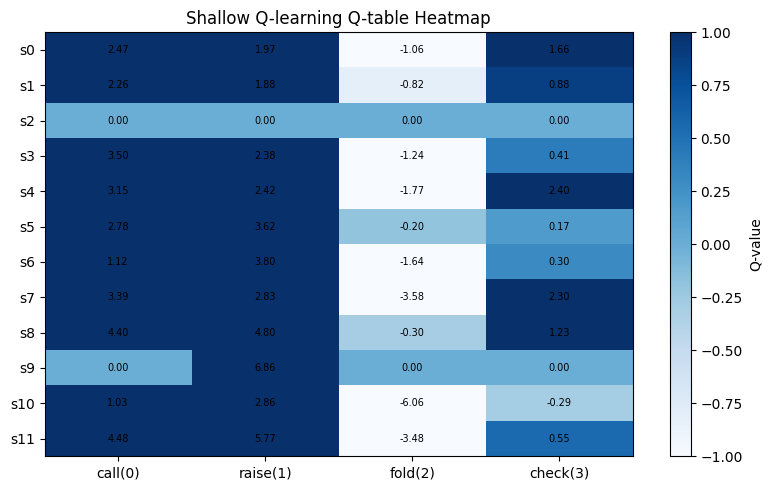

[Q-learning vs Random] over 500 episodes:
  Win rate : 0.954
  Tie rate : 0.004
  Loss rate: 0.042
  Mean reward: 1.990
========== Comparison: Rule-based vs Shallow Q-learning ==========
Rule-based: mean reward=0.568, win rate=0.600
Shallow Q:  mean reward=1.990, win rate=0.954


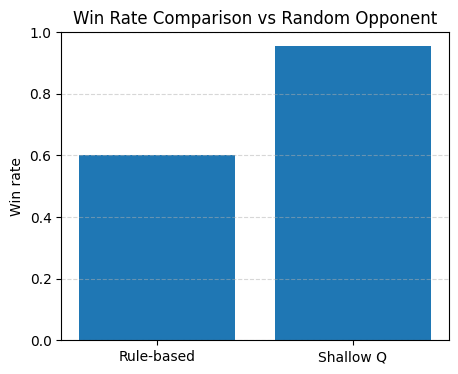

In [3]:
# -------- 1. 先跑 Rule-based baseline --------
rule_rewards = collect_rule_based_stats(num_episodes=500)
# 这里已经打印出 win/tie/loss 和 mean reward

# -------- 2. 训练 Shallow Q-learning --------
Q, episode_rewards = shallow_train(num_episodes=5000)

# 学习曲线
plot_learning_curve(episode_rewards, window=50)

# Q-table 热力图
plot_q_heatmap(Q)

# -------- 3. 评估 Shallow Q-learning --------
q_rewards = evaluate_q_policy(Q, num_episodes=500)

# -------- 4. 和 Rule-based 做对比 --------
compare_rule_vs_q(rule_rewards, q_rewards)


In [7]:
def collect_rule_based_action_distribution(num_episodes=300):
    """
    统计 rule-based 在多个 episode 中采取的动作频率。
    使用你已有的 rule_based_action()，环境同样是 random 对手。
    """
    action_counts = np.zeros(4, dtype=int)  # 对应动作 0/1/2/3

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            if termination or truncation:
                action = None
            else:
                mask = np.asarray(obs["action_mask"])
                legal = np.where(mask > 0)[0]

                if agent == "player_0":
                    action = rule_based_action(obs, verbose=False)
                else:
                    action = int(np.random.choice(legal))

                if agent == "player_0":
                    action_counts[action] += 1

            env.step(action)
        env.close()

    return action_counts

def plot_rule_based_distribution(counts):
    labels = ["Call (0)", "Raise (1)", "Fold (2)", "Check (3)"]
    colors = ["steelblue", "tomato", "gray", "green"]

    plt.figure(figsize=(7,4))
    plt.bar(labels, counts, color=colors)
    plt.title("Rule-based Policy Action Distribution")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()


Action counts: [219  17 108 152]


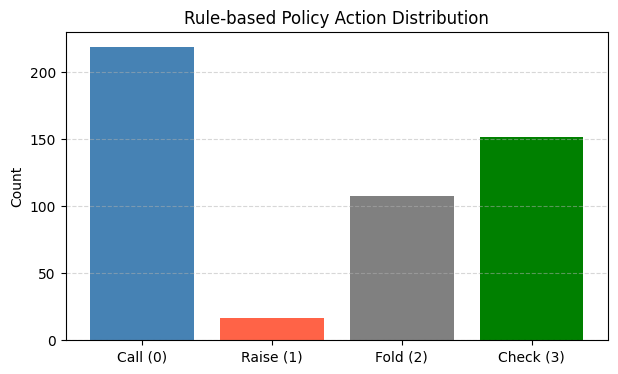

In [8]:
counts = collect_rule_based_action_distribution(num_episodes=300)
print("Action counts:", counts)

plot_rule_based_distribution(counts)


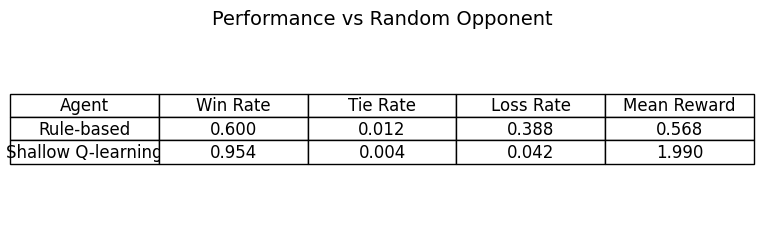

In [4]:
import matplotlib.pyplot as plt

# Data for table 1
data1 = [
    ["Rule-based", "0.600", "0.012", "0.388", "0.568"],
    ["Shallow Q-learning", "0.954", "0.004", "0.042", "1.990"]
]

columns1 = ["Agent", "Win Rate", "Tie Rate", "Loss Rate", "Mean Reward"]

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('tight')
ax.axis('off')

table1 = ax.table(
    cellText=data1,
    colLabels=columns1,
    loc='center',
    cellLoc='center'
)

table1.auto_set_font_size(False)
table1.set_fontsize(12)
table1.scale(1.2, 1.4)

plt.title("Performance vs Random Opponent", fontsize=14)
plt.savefig("table_performance_random.png", dpi=200, bbox_inches='tight')
plt.show()


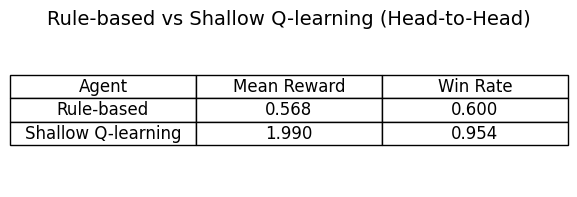

In [5]:
import matplotlib.pyplot as plt

# Data for table 2
data2 = [
    ["Rule-based", "0.568", "0.600"],
    ["Shallow Q-learning", "1.990", "0.954"]
]

columns2 = ["Agent", "Mean Reward", "Win Rate"]

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')

table2 = ax.table(
    cellText=data2,
    colLabels=columns2,
    loc='center',
    cellLoc='center'
)

table2.auto_set_font_size(False)
table2.set_fontsize(12)
table2.scale(1.2, 1.4)

plt.title("Rule-based vs Shallow Q-learning (Head-to-Head)", fontsize=14)
plt.savefig("table_head_to_head.png", dpi=200, bbox_inches='tight')
plt.show()
